### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

2024-07-11 11:56:45.666916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 11:56:45.824928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 11:56:45.906367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 11:56:45.906896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 11:56:46.015901: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
from datasets import Dataset

train_ds = Dataset.from_dict({ 'text': processed_texts, 'label': labels })
val_ds = Dataset.from_dict({ 'text': processed_val_texts, 'label': val_labels })

In [5]:
train_ds[0]

{'text': 'need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'label': 0}

### Creating the Model

#### Vectorization

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [9]:
tokenized_texts = train_ds.map(preprocess_function, batched=True)
tokenized_val_texts = val_ds.map(preprocess_function, batched=True)


Map:   0%|          | 0/185658 [00:00<?, ? examples/s]

Map:   0%|          | 0/23208 [00:00<?, ? examples/s]

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

### Evaluate

In [11]:
import evaluate

accuracy = evaluate.load("accuracy")

In [12]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### Creating the model

In [13]:
id2label = {0: "Depressed", 1: "Happy"}
label2id = {"Depressed": 0, "Happy": 1}

In [14]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_texts) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

2024-07-11 11:57:20.300018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:57:20.306776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:57:20.310376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [17]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_texts,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_val_set = model.prepare_tf_dataset(
    tokenized_val_texts,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

In [18]:
import tensorflow as tf

model.compile(optimizer=optimizer)

In [19]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_set)

In [20]:
callbacks = [metric_callback]

In [21]:
model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=3, callbacks=callbacks)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720713585.615107    6238 service.cc:145] XLA service 0x7debe89c55d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720713585.615122    6238 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-11 11:59:45.623478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 11:59:45.643970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1720713585.696208    6238 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   61/11603 [..............................] - ETA: 1:13:06 - loss: 0.4292

2024-07-11 12:00:23.179875: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 192.00MiB (rounded to 201326592)requested by op tf_roberta_for_sequence_classification/roberta/encoder/layer_._7/attention/self/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-11 12:00:23.179957: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-07-11 12:00:23.179977: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 108, Chunks in use: 108. 27.0KiB allocated for chunks. 27.0KiB in use in bin. 721B client-requested in use in bin.
2024-07-11 12:00:23.179988: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use i

ResourceExhaustedError: Graph execution error:

Detected at node tf_roberta_for_sequence_classification/roberta/encoder/layer_._7/attention/self/Softmax defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_3256/3181606330.py", line 1, in <module>

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/modeling_tf_utils.py", line 1229, in fit

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/modeling_tf_utils.py", line 1669, in train_step

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/modeling_tf_utils.py", line 1672, in train_step

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/modeling_tf_utils.py", line 1420, in run_call_with_unpacked_inputs

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 1432, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/modeling_tf_utils.py", line 1420, in run_call_with_unpacked_inputs

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 827, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 610, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 616, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 508, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 389, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_fileezgse7nr.py", line 34, in error_handler

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 300, in call

  File "/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/tf_utils.py", line 72, in stable_softmax

OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tf_roberta_for_sequence_classification/roberta/encoder/layer_._7/attention/self/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_32224]

### Evaluating the Model

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_ds = Dataset.from_dict({ 'text': processed_test_texts, 'label': test_labels })
tokenized_test_texts = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/23208 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_texts = [tokenizer(text, truncation=True, return_tensors='tf') for text in processed_test_texts]

In [ ]:
logits = [model(**tokenized_test_text).logits for tokenized_test_text in tokenized_test_texts]

In [ ]:
y_pred = [int(tf.math.argmax(logit, axis=-1)[0]) for logit in logits]
# y_pred = (y_pred > 0.5).astype(int)

# y_pred = np.array(list(map(lambda x: x[0], y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0275
False Negative Rate: 0.0295
accuracy_score 0.971
precision_score 0.972
recall_score 0.970
f1_score 0.971


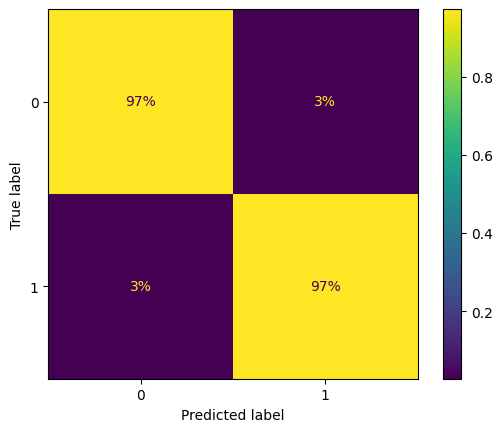

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()

In [ ]:
import pickle

with open('./models/hug_clf.pkl', 'wb') as fp:
  pickle.dump(model, fp)

with open('./models/hug_tok.pkl', 'wb') as fp:
  pickle.dump(tokenizer, fp)

/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
